<div style="text-align: center; margin-top: 50px; margin-bottom: 30px;">
    <h1 style="font-size: 3em; color:#00E0FF;">Payment Analysis Test Case</h1>
    <h3 style="font-size: 2em; color: #E3BD00;">Clesson Roberto da Silva Junior</h3>
    
</div>

---

## Description

In this analysis, I will use Python to process and analyze the data, extracting as much information as possible. Subsequently, I will heavily research and implement the best machine learning model to predict fraud.


- Things to watch for:

  - Latency
  - Security
  - Architecture
  - Coding style

- Antifraud Requirements
  - Reject transaction if user is trying **too many transactions in a row**;
    - Search for usual number used for this;
  - Reject transactions above a **certain amount in a given period**;
    - Try to find common values in fraudster transactions and times where fraud is more likely to occur.
  - Reject transaction **if a user had a chargeback before** (note that this information does not comes on the payload. The chargeback data is received days after the transaction was approved)
    - The card has been "canceled", so there is no reason to accept a transaction.


From all my previous experiences, the Google Framework is the best way to analyze data. But how it works? 

## Google Analytics Steps

<ol style="font-size: 1.2em; color: #F3CF1D; line-height: 1.5;">
  <li><strong>Ask</strong> - Define the questions you want to answer.</li>
  <li><strong>Prepare</strong> - Collect and prepare your data for analysis.</li>
  <li><strong>Process</strong> - Clean and transform the data to ensure accuracy.</li>
  <li><strong>Analyze</strong> - Examine the data to find insights and patterns.</li>
  <li><strong>Share</strong> - Present your findings to stakeholders.</li>
  <li><strong>Act</strong> - Make decisions and take actions based on the analysis.</li>
</ol>

So, let's get into our first section, to ask the questions.

---

## <span style="color:#F7A454">1. Asking the questions</span>


## Common Findings in Fraud Detection

Here are some of the most common findings when identifying fraud in credit card data:

1. **Unusual Transaction Amounts**: Transactions that are significantly higher or lower than the average transaction amounts.
2. **Multiple Transactions in a Short Time Frame**: Numerous transactions occurring within a very short period.
3. **Transactions from Different Geographic Locations**: Transactions made from locations that are significantly different from the cardholder’s usual locations.
4. **Inconsistent Merchant Categories**: Purchases from merchant categories that are unusual for the cardholder.
5. **Odd Hours Transactions**: Transactions made at times that are unusual for the cardholder.
6. **Frequent Chargebacks**: A high number of chargebacks associated with the cardholder's account.

### Key Questions to Ask:

1. **Are there any transactions that significantly deviate from the cardholder’s typical spending patterns?**
2. **Are there clusters of transactions occurring in a very short period?**
3. **Do any transactions originate from geographic locations far from the cardholder’s usual area?**
4. **Are there purchases from merchant categories that are atypical for the cardholder?**
5. **Do any transactions occur at odd hours, compared to the cardholder’s normal activity?**
6. **Is there a high frequency of chargebacks, and what are the reasons for these chargebacks?**

Not all the questions must be answered perfectly, but now I've a guide. **So, let's prepare the data.**

---

## <span style="color:#F7A454">2. Preparing the data.</span>

#### Importing Lib's

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

#### Taking a look at the data

In [3]:
df = pd.read_csv('transactions.csv')
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())


   transaction_id  merchant_id  user_id       card_number  \
0        21320398        29744    97051  434505******9116   
1        21320399        92895     2708  444456******4210   
2        21320400        47759    14777  425850******7024   
3        21320401        68657    69758  464296******3991   
4        21320402        54075    64367  650487******6116   

             transaction_date  transaction_amount  device_id  has_cbk  
0  2019-12-01T23:16:32.812632              374.56   285475.0    False  
1  2019-12-01T22:45:37.873639              734.87   497105.0     True  
2  2019-12-01T22:22:43.021495              760.36        NaN    False  
3  2019-12-01T21:59:19.797129             2556.13        NaN     True  
4  2019-12-01T21:30:53.347051               55.36   860232.0    False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----

In [4]:
num_cbk_true = df[df['has_cbk'] == True].shape[0]
print("Number of rows with 'has_cbk' = True:", num_cbk_true)

Number of rows with 'has_cbk' = True: 391


### Brief Analysis

I have the common practice of looking at the absolutely raw data and making a quick analysis, here is what I found out.

The card number is currently masked with asterisks, which hinders its usability. I will remove the asterisks to make the data more accessible for analysis.

Regarding the null values in the device_id column, this anomaly warrants further investigation. It is possible that individuals with null device IDs may be either important users who prioritize their device privacy or potential fraudsters attempting to conceal their identity. This aspect requires deeper analysis to discern patterns and potential implications.

The std is higher than the mean in the "transaction_amount" column, so the amount variability is high. So these questions come to mind:
 - Are there any specific transaction amounts or ranges that are more common or less common? 
 - Are there any outliers in transaction amounts that warrant further investigation?

Transaction data is an object, convert it to time frame

It's a common practice in carding (the act of using fraudulent credit cards), a common tactic involves attempting multiple cards with altered details but under the same merchant ID. This practice is aimed at impersonating different individuals while maintaining consistency with the merchant. To detect potential instances of this, I will analyze transactions with similar amounts occurring within the same merchant and occurring within a short timeframe, approximately 30 minutes. If a specific merchant has a lot of fraudulents attemps (chargebacks) it may indicate some infosec problem.

Very low amounts may also indicate that a hacker is trying to test if the stolen CC info is working or not.

Cluster plot the merchant id

The number of "fraudlent" transactions is very tiny for a ML model to obtain useful performance, so **augmentation** may be necessary.

Plot only the fraudlent transactions by time of the day.


---

## <span style="color:#F7A454">3. Processing the data.</span>

In [5]:
# Removing asterisk from CC info
df['card_number'] = df['card_number'].str.replace('*', '')
df['card_number'] = df['card_number'].astype('int64')
#? Converting date to datetime, I'll separate the date and time.
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_day'] = pd.to_datetime(df['transaction_date'].dt.date) #? Converting to datetime

df['transaction_time'] = df['transaction_date'].dt.time
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S.%f')#? Converting to datetime
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   int64         
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   float64       
 7   has_cbk             3199 non-null   bool          
 8   transaction_day     3199 non-null   datetime64[ns]
 9   transaction_time    3199 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), float64(2), int64(4)
memory usage: 228.2 KB
None


C:\Users\PC\AppData\Local\Temp\ipykernel_2756\3320557203.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['card_number'] = df['card_number'].str.replace('*', '')


Now that the data has been cleaned, let's understand it.

## <span style="color:#F7A454">4. Analyzing the data.</span>

#### Transaction Frequency over time.
Let's check transactions flow through the year.

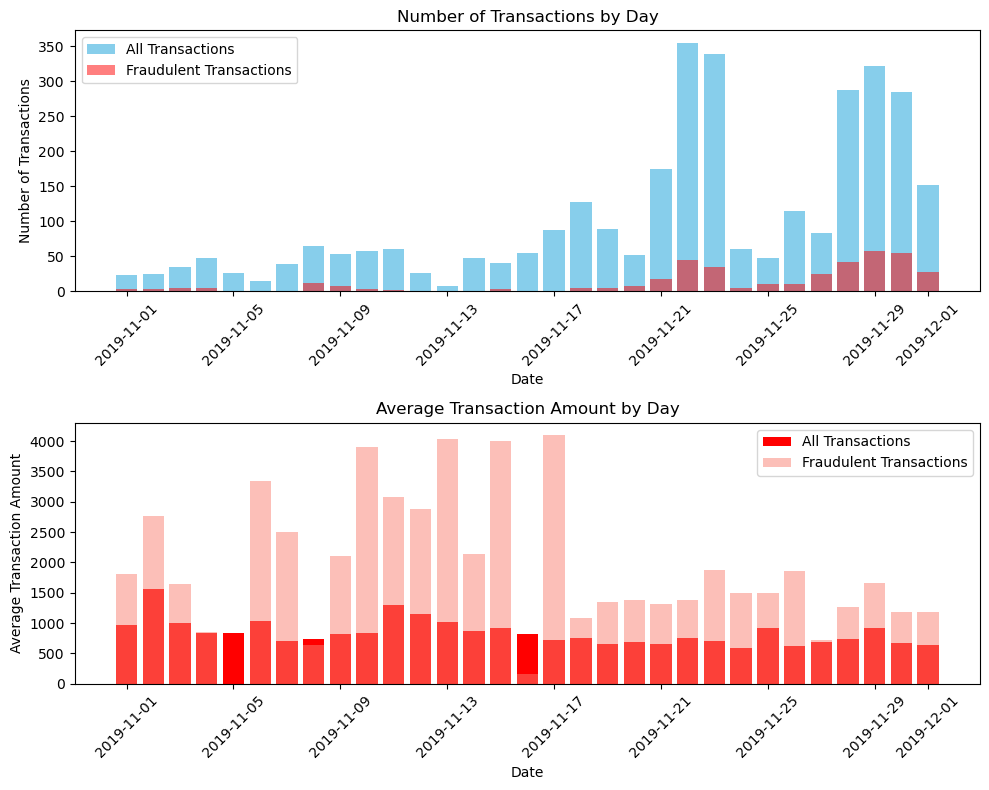

In [6]:


# Filter for fraudulent transactions
fraud_transactions = df[df['has_cbk'] == True]

# Group by transaction_day for all transactions
transactions_by_day = df.groupby('transaction_day').size()
average_amount_by_day = df.groupby('transaction_day')['transaction_amount'].mean()

# Group by transaction_day for fraudulent transactions
fraud_transactions_by_day = fraud_transactions.groupby('transaction_day').size()
average_fraud_amount_by_day = fraud_transactions.groupby('transaction_day')['transaction_amount'].mean()

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot number of transactions by day
axes[0].bar(transactions_by_day.index, transactions_by_day.values, color='skyblue', label='All Transactions')
axes[0].bar(fraud_transactions_by_day.index, fraud_transactions_by_day.values, color='red', alpha=0.5, label='Fraudulent Transactions')
axes[0].set_title('Number of Transactions by Day')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
axes[0].legend()

# Plot average transaction amount by day
axes[1].bar(average_amount_by_day.index, average_amount_by_day.values, color='red', label='All Transactions')
axes[1].bar(average_fraud_amount_by_day.index, average_fraud_amount_by_day.values, color='salmon', alpha=0.5, label='Fraudulent Transactions')
axes[1].set_title('Average Transaction Amount by Day')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Transaction Amount')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### Now, let's see usual transaction amount by time of day, and usual frequency by time of day.

C:\Users\PC\AppData\Local\Temp\ipykernel_2756\3028182916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions['transaction_time_minute'] = fraud_transactions['transaction_time'].dt.round('min')


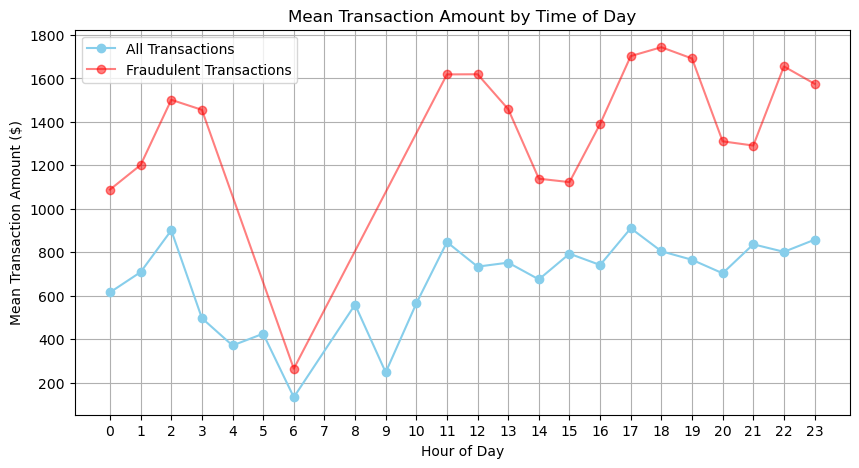

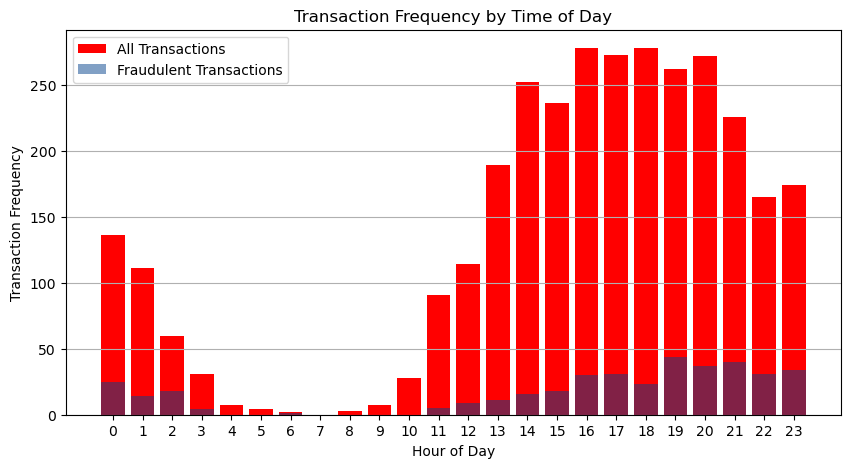

In [7]:


# Round transaction time to the nearest minute
df['transaction_time_minute'] = df['transaction_time'].dt.round('min')
fraud_transactions['transaction_time_minute'] = fraud_transactions['transaction_time'].dt.round('min')

# Group by transaction time (hour component) and calculate mean transaction amount and transaction count
transaction_amount_by_hour = df.groupby(df['transaction_time_minute'].dt.hour)['transaction_amount'].mean()
transaction_count_by_hour = df.groupby(df['transaction_time_minute'].dt.hour).size()

# Group fraudulent transactions by transaction time (hour component)
fraud_transaction_amount_by_hour = fraud_transactions.groupby(fraud_transactions['transaction_time_minute'].dt.hour)['transaction_amount'].mean()
fraud_transaction_count_by_hour = fraud_transactions.groupby(fraud_transactions['transaction_time_minute'].dt.hour).size()

# Plot the mean transaction amount by hour
plt.figure(figsize=(10, 5))
plt.plot(transaction_amount_by_hour.index, transaction_amount_by_hour.values, marker='o', color='skyblue', label='All Transactions')
plt.plot(fraud_transaction_amount_by_hour.index, fraud_transaction_amount_by_hour.values, marker='o', color='red', alpha=0.5, label='Fraudulent Transactions')
plt.title('Mean Transaction Amount by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Transaction Amount ($)')
plt.xticks(range(24))  # Set x-axis ticks to 0-23 (hours)
plt.grid(True)
plt.legend()
plt.show()

# Plot the transaction frequency by hour
plt.figure(figsize=(10, 5))
plt.bar(transaction_count_by_hour.index, transaction_count_by_hour.values, color='red', label='All Transactions')
plt.bar(fraud_transaction_count_by_hour.index, fraud_transaction_count_by_hour.values, color='#04438C', alpha=0.5, label='Fraudulent Transactions')
plt.title('Transaction Frequency by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Frequency')
plt.xticks(range(24))  # Set x-axis ticks to 0-23 (hours)
plt.grid(axis='y')  # Show grid lines only on y-axis
plt.legend()
plt.show()


- The data is in a tight timeframe 2019-11-01 -> 2019-12-01, almost a full month of transactions

- At 2019-11-22, 2019-11-23 -> 56th anniversary of the assassination of President John F. Kennedy in Dallas, Texas, but it doesn't seems to able to create such volume, very strange.

- 2019-11-28, 2019-11-29, 2019-11-30 -> Possibly thanksgiving day, hence the big volume, but it needs further investigation. (I'm possibly considering this data comes from the USA)

- Unusual high average transcation amount at:
  - 2019-11-02 -> No reason
  - 2019-11-05 -> No reason
  - 2019-11-11 -> Veterans Day in the United States
  
- 4-9 AM is clearly a unusual time to make transactions.
- 13 PM - 00:00 AM seems to be the "usual" time for making transactions.

- Fraudlent transactions seems to follow the same time frame, and they happen in a way way less frequencies.
- Fraudster are trying to emulate the usual costumer behavior (at least by the time of the day the purchase has been made).

- Fraudlent transaction usually have a way higher cash amount. 3~4k is a very dangerous region.


### Transaction Amount Distribution

In [8]:
fraud_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 1 to 3185
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           391 non-null    int64         
 1   merchant_id              391 non-null    int64         
 2   user_id                  391 non-null    int64         
 3   card_number              391 non-null    int64         
 4   transaction_date         391 non-null    datetime64[ns]
 5   transaction_amount       391 non-null    float64       
 6   device_id                324 non-null    float64       
 7   has_cbk                  391 non-null    bool          
 8   transaction_day          391 non-null    datetime64[ns]
 9   transaction_time         391 non-null    datetime64[ns]
 10  transaction_time_minute  391 non-null    datetime64[ns]
dtypes: bool(1), datetime64[ns](4), float64(2), int64(4)
memory usage: 34.0 KB


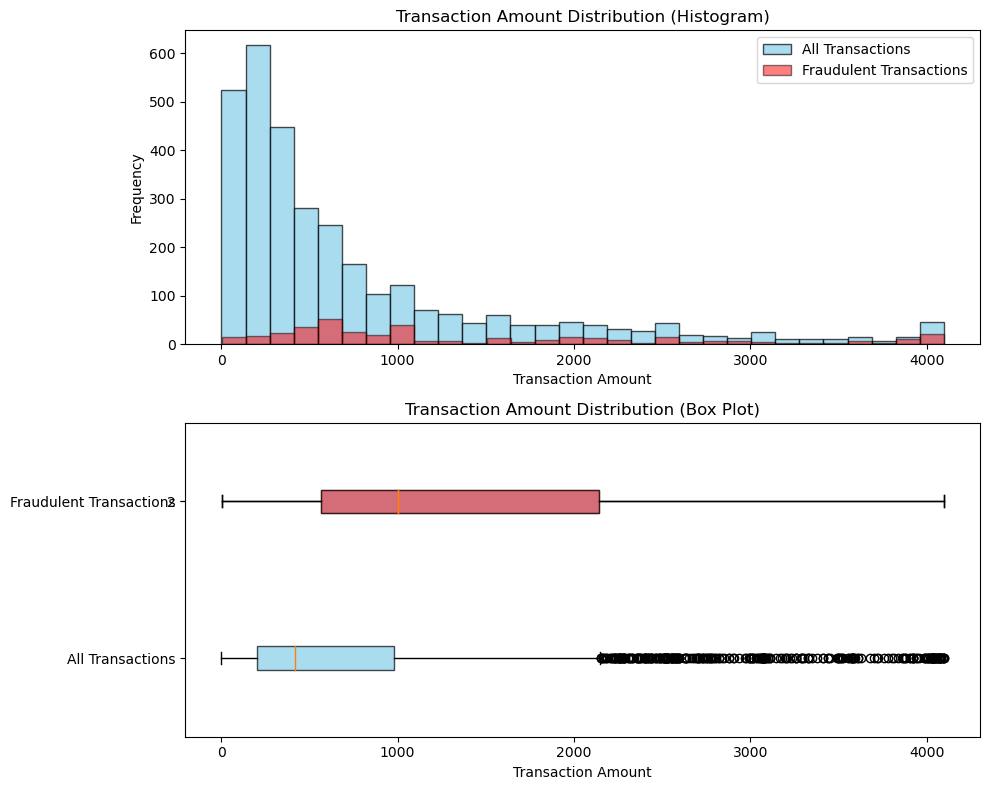

Summary Statistics for All Transactions:
Mean Transaction Amount: 767.8129040325101
Median Transaction Amount: 415.94
Standard Deviation of Transaction Amount: 889.0959040800284

Summary Statistics for Fraudulent Transactions:
Mean Fraudulent Transaction Amount: 1453.5719181585678
Median Fraudulent Transaction Amount: 999.47
Standard Deviation of Fraudulent Transaction Amount: 1169.4913457469793


In [9]:
# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram of transaction amounts
axes[0].hist(df['transaction_amount'], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='All Transactions')
axes[0].hist(fraud_transactions['transaction_amount'], bins=30, color='red', edgecolor='black', alpha=0.5, label='Fraudulent Transactions')
axes[0].set_title('Transaction Amount Distribution (Histogram)')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot box plot of transaction amounts
axes[1].boxplot([df['transaction_amount'], fraud_transactions['transaction_amount']], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', alpha=0.7), labels=['All Transactions', 'Fraudulent Transactions'])
# Add another box plot for fraudulent transactions with different color
axes[1].boxplot(fraud_transactions['transaction_amount'], vert=False, patch_artist=True,
                boxprops=dict(facecolor='red', alpha=0.5), positions=[2])
axes[1].set_title('Transaction Amount Distribution (Box Plot)')
axes[1].set_xlabel('Transaction Amount')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Calculate summary statistics for all transactions
mean_transaction_amount = df['transaction_amount'].mean()
median_transaction_amount = df['transaction_amount'].median()
std_transaction_amount = df['transaction_amount'].std()

print("Summary Statistics for All Transactions:")
print(f"Mean Transaction Amount: {mean_transaction_amount}")
print(f"Median Transaction Amount: {median_transaction_amount}")
print(f"Standard Deviation of Transaction Amount: {std_transaction_amount}")

# Calculate summary statistics for fraudulent transactions
mean_fraud_transaction_amount = fraud_transactions['transaction_amount'].mean()
median_fraud_transaction_amount = fraud_transactions['transaction_amount'].median()
std_fraud_transaction_amount = fraud_transactions['transaction_amount'].std()

print("\nSummary Statistics for Fraudulent Transactions:")
print(f"Mean Fraudulent Transaction Amount: {mean_fraud_transaction_amount}")
print(f"Median Fraudulent Transaction Amount: {median_fraud_transaction_amount}")
print(f"Standard Deviation of Fraudulent Transaction Amount: {std_fraud_transaction_amount}")


- There are a ton of "outlier" transactions, and transactions between 3000 and 4000 seems to not be quite common. 

- An usual amount seems like to be between 415 and 767.


### Merchant Analysis

C:\Users\PC\AppData\Local\Temp\ipykernel_2756\3661838185.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_merchant_transactions['transaction_day'] = top_merchant_transactions['transaction_day'].dt.date


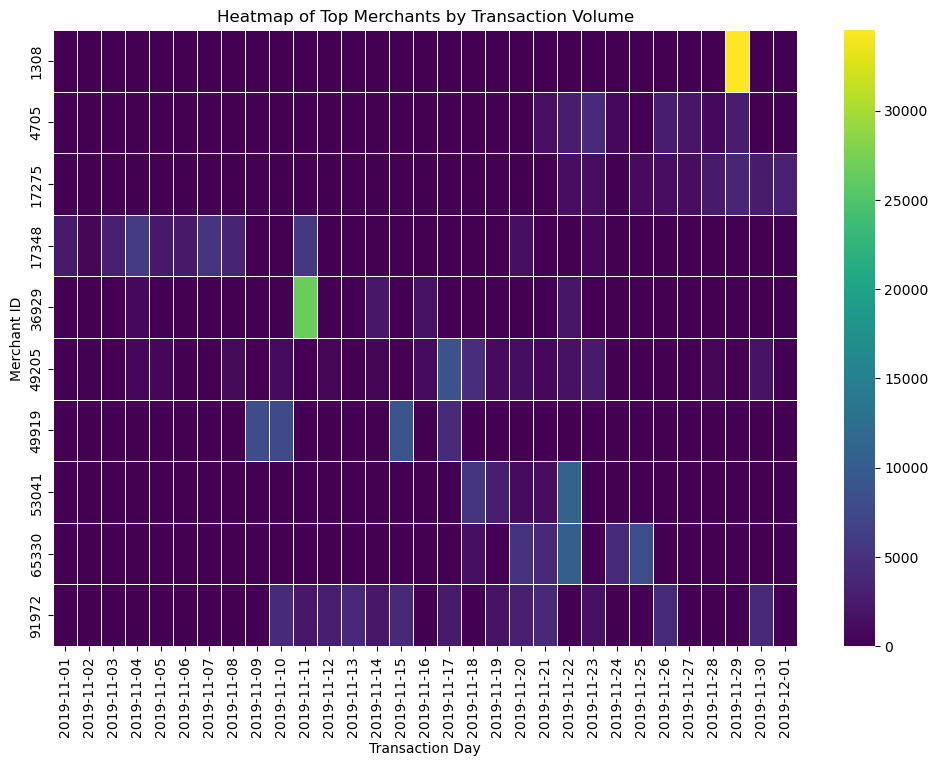

C:\Users\PC\AppData\Local\Temp\ipykernel_2756\3661838185.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_fraud_merchant_transactions['transaction_day'] = top_fraud_merchant_transactions['transaction_day'].dt.date


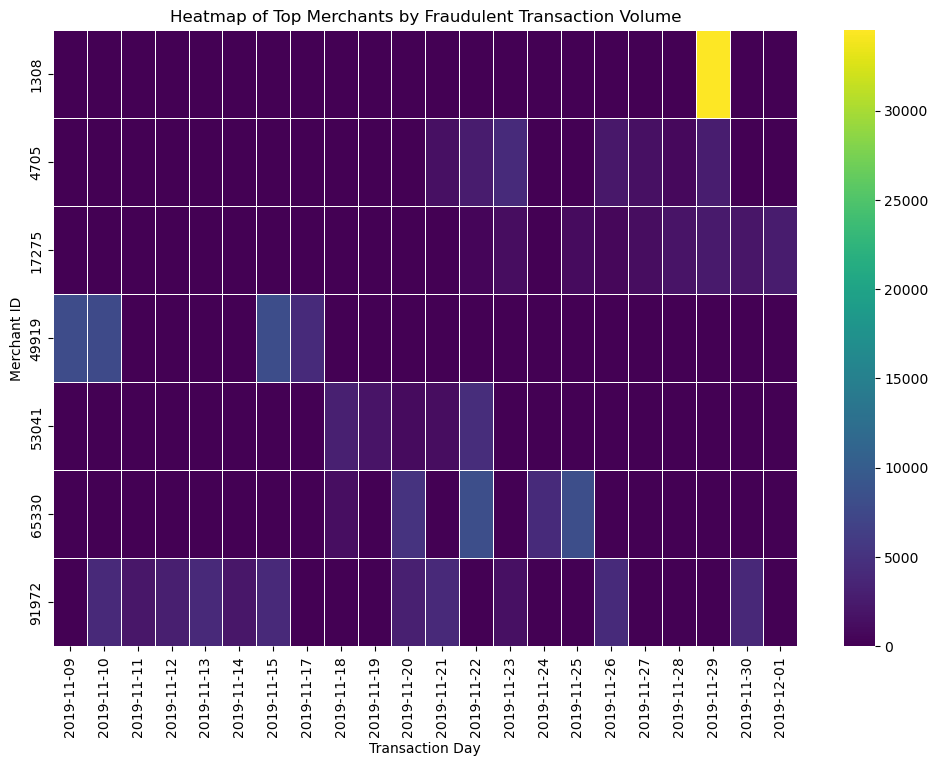

In [10]:


# Filter for top merchants
merchant_transaction_volume = df.groupby('merchant_id')['transaction_amount'].sum()
top_merchants = merchant_transaction_volume.sort_values(ascending=False).head(10)
top_merchant_transactions = df[df['merchant_id'].isin(top_merchants.index)]

# Extract the day component from the transaction_day column
top_merchant_transactions['transaction_day'] = top_merchant_transactions['transaction_day'].dt.date

# Create a pivot table of top merchant transactions
merchant_pivot = top_merchant_transactions.pivot_table(index='merchant_id', columns='transaction_day', values='transaction_amount', aggfunc='sum', fill_value=0)

# Create a heatmap for all transactions
plt.figure(figsize=(12, 8))
sns.heatmap(merchant_pivot, cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Top Merchants by Transaction Volume')
plt.xlabel('Transaction Day')
plt.ylabel('Merchant ID')
plt.show()

# Filter for fraudulent transactions
fraud_transactions = df[df['has_cbk'] == True]
top_fraud_merchant_transactions = fraud_transactions[fraud_transactions['merchant_id'].isin(top_merchants.index)]

# Extract the day component from the transaction_day column
top_fraud_merchant_transactions['transaction_day'] = top_fraud_merchant_transactions['transaction_day'].dt.date

# Create a pivot table of top merchant fraudulent transactions
fraud_merchant_pivot = top_fraud_merchant_transactions.pivot_table(index='merchant_id', columns='transaction_day', values='transaction_amount', aggfunc='sum', fill_value=0)

# Create a heatmap for fraudulent transactions
plt.figure(figsize=(12, 8))
sns.heatmap(fraud_merchant_pivot, cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Top Merchants by Fraudulent Transaction Volume')
plt.xlabel('Transaction Day')
plt.ylabel('Merchant ID')
plt.show()


Nothing unusual here, just important to notice that the merchant 1208 had a lot of transactions on 2019-11-30

## User Behavior Analysis

In [13]:
from scipy.stats import zscore


# Step 1: Calculate User Transaction Frequency
user_transaction_frequency = df.groupby('user_id').size().reset_index(name='transaction_count')

# Step 2: Calculate Average Transaction Amount Per User
user_avg_transaction_amount = df.groupby('user_id')['transaction_amount'].mean().reset_index(name='average_transaction_amount')

# Step 3: Identify Preferred Merchants for Each User
user_preferred_merchants = df.groupby(['user_id', 'merchant_id']).size().reset_index(name='transaction_count')
user_preferred_merchants = user_preferred_merchants.loc[user_preferred_merchants.groupby('user_id')['transaction_count'].idxmax()]

# Step 4: Identify Outliers or Unusual Behavior
# Using z-score to identify outliers
user_transaction_frequency['z_score_transaction_count'] = zscore(user_transaction_frequency['transaction_count'])
user_avg_transaction_amount['z_score_avg_amount'] = zscore(user_avg_transaction_amount['average_transaction_amount'])

# Define thresholds for outliers
transaction_count_threshold = 3
transaction_amount_threshold = 3

# Identify users with unusually high transaction frequency or amount
outliers_transaction_count = user_transaction_frequency[user_transaction_frequency['z_score_transaction_count'].abs() > transaction_count_threshold]
outliers_transaction_amount = user_avg_transaction_amount[user_avg_transaction_amount['z_score_avg_amount'].abs() > transaction_amount_threshold]

# Print outliers
print("Users with Unusually High Transaction Frequency:")
print(outliers_transaction_count)

print("\nUsers with Unusually High Average Transaction Amount:")
print(outliers_transaction_amount)


Users with Unusually High Transaction Frequency:
      user_id  transaction_count  z_score_transaction_count
103      3584                  6                   4.577419
209      7695                  7                   5.527694
211      7725                  7                   5.527694
254      9853                  9                   7.428245
267     10241                  5                   3.627143
293     11452                  8                   6.477970
302     11750                 31                  28.334309
484     17929                  6                   4.577419
584     21768                  6                   4.577419
723     27657                  5                   3.627143
741     28218                  5                   3.627143
907     34548                  6                   4.577419
1056    40779                  6                   4.577419
1112    42677                  5                   3.627143
1279    49106                  7                   

In [21]:
def charge_back_percentage(df,id):
    df = df[df['user_id'] == id]
    total_transactions = df.shape[0]
    total_cbk = df[df['has_cbk'] == True].shape[0]
    cbk_percentage = (total_cbk / total_transactions) * 100
    return cbk_percentage

In [23]:
# User_id 11750 it's most definetely a fraudster.
charge_back_percentage(df,11750)

80.64516129032258

In [24]:
# User_id 11750 it's most definetely a fraudster.
charge_back_percentage(df,91637)

86.36363636363636

It's feasible to think that id's with a high z-score's are mostly fraudsters.

### Device Usage Analysis

In [34]:
devices = df[df['has_cbk'] == True]
devices[devices['device_id'].isnull()].shape[0]

67

Unknow devices does not seem to be correlated with fraud.

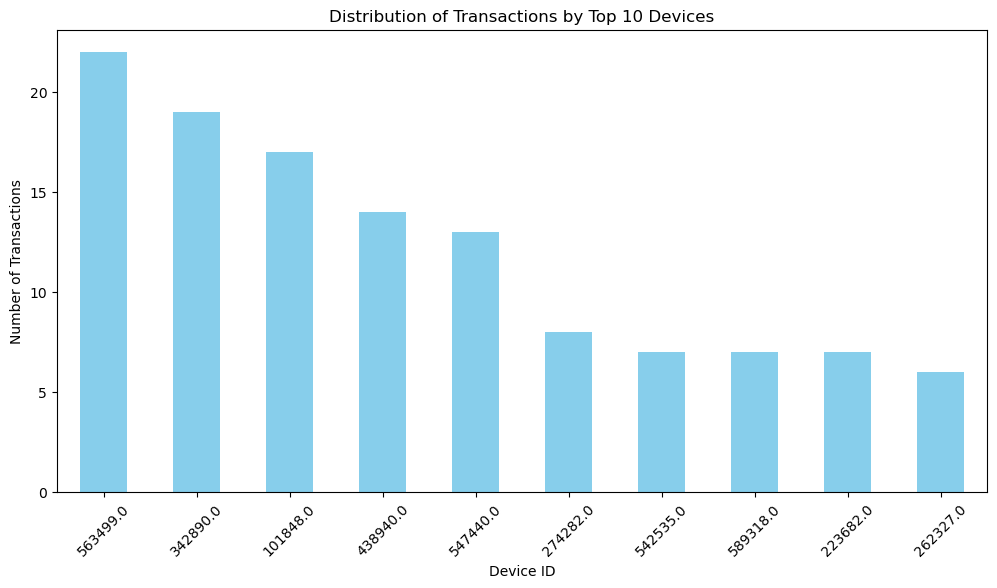

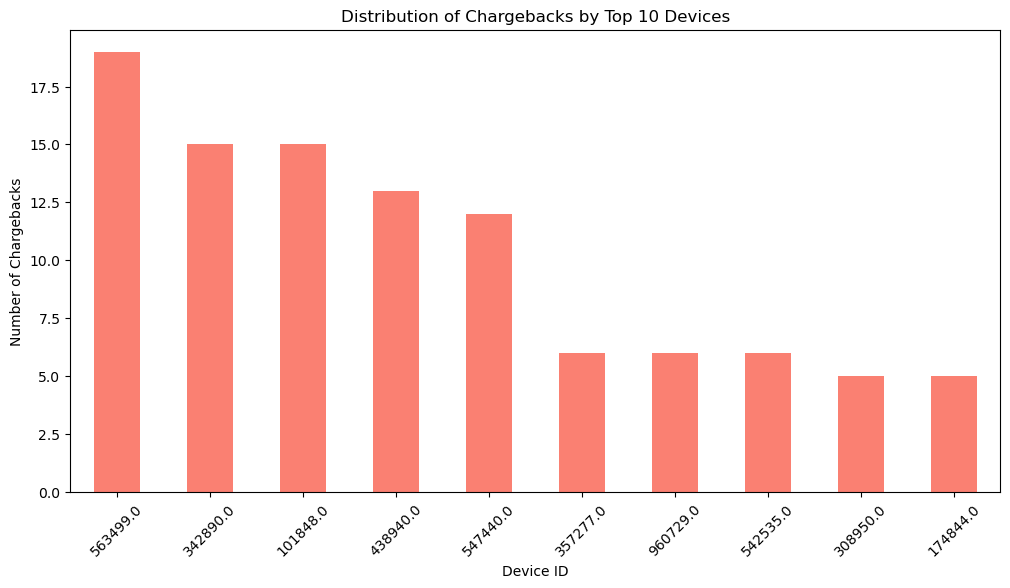

In [37]:
# Group transactions by device_id and count the number of transactions
device_transaction_counts = df['device_id'].value_counts()

# Select the top 10 devices by transaction count
top_device_transaction_counts = device_transaction_counts.head(10)

# Plot the distribution of transactions by top 10 devices
plt.figure(figsize=(12, 6))
top_device_transaction_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Transactions by Top 10 Devices')
plt.xlabel('Device ID')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Filter transactions where has_cbk is True
chargeback_transactions = df[df['has_cbk'] == True]

# Group chargeback transactions by device_id and count them
device_chargeback_counts = chargeback_transactions['device_id'].value_counts()

# Select the top 10 devices by chargeback count
top_device_chargeback_counts = device_chargeback_counts.head(10)

# Plot the distribution of chargebacks by top 10 devices
plt.figure(figsize=(12, 6))
top_device_chargeback_counts.plot(kind='bar', color='salmon')
plt.title('Distribution of Chargebacks by Top 10 Devices')
plt.xlabel('Device ID')
plt.ylabel('Number of Chargebacks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



The top 5 devices (considering transactions number) are most definetely fraudsters, 563499, 342890, 101848, 438940, 547440

### Correlation Analysis

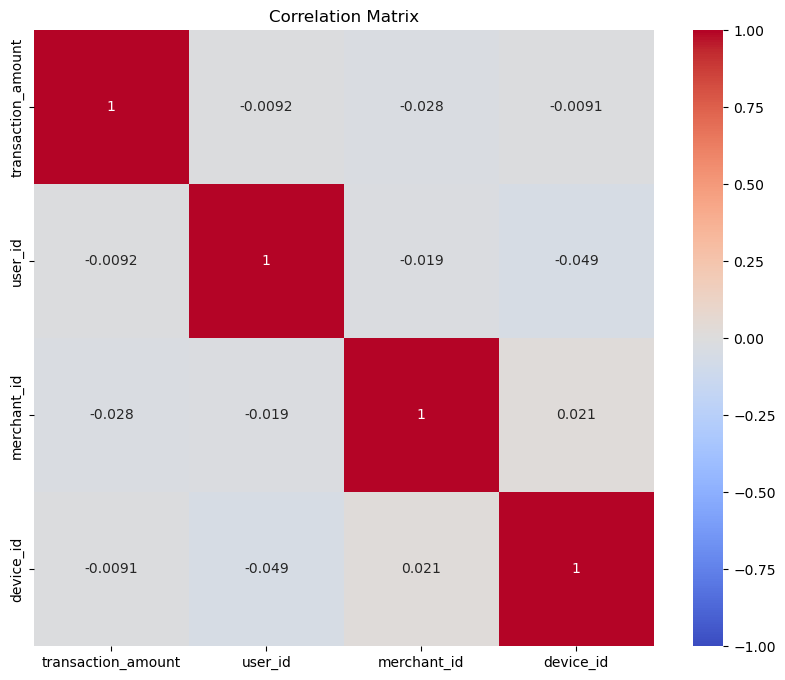

Significant Correlations (absolute value > 0.5):
 Empty DataFrame
Columns: []
Index: []


In [38]:
# Selecting numerical columns for correlation analysis
numerical_columns = ['transaction_amount', 'user_id', 'merchant_id', 'device_id']

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

# Analyze significant correlations (absolute value greater than a threshold, e.g., 0.5)
threshold = 0.5
significant_correlations = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)].dropna(how='all', axis=0).dropna(how='all', axis=1)
print("Significant Correlations (absolute value > 0.5):\n", significant_correlations)


There are no significant correlations between the nmmumerical columns in the dataset. This suggests that the numerical features are not strongly correlated with each other, which is a good sign for building a predictive model.
